In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import os,sys
import random
from skimage.transform import resize
import models
sys.path.insert(0,'/home/huangz78/hydro/unet3d/')
import torch.fft as F
from models.unet3d_model import UNet3D, ResidualUNet3D 
from models.dnet import weights_init, Discriminator
import utils
from utils import *
# from train import gan_train,noise_generate
from importlib import reload
from scipy.interpolate import griddata

from torch.autograd import Variable
import copy

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [10]:
reload(utils)
from utils import *

# track adversial training errors

In [ ]:
errorRec_path = '/mnt/DataA/checkpoints/leo/hydro/wgan_train_track_Abel-gaussian.npz'
errordata = np.load(errorRec_path)
%matplotlib notebook
%matplotlib inline
print(errordata.files)

In [ ]:
np.argmin(errordata['nrmse_val'])

In [ ]:
visualization(errordata,errordata.files,log=False,figsize=(10,35))

# check denoised slices

In [ ]:
# load a G net
# gnet = UNet3D(1,1,is_segmentation=False,final_sigmoid=False)
gnet = ResidualUNet3D(1,1,num_levels=4,is_segmentation=False,final_sigmoid=False)
gpath = '/mnt/DataA/checkpoints/leo/hydro/netG_wg_Abel-gaussian_epoch_3.pt'
# # gpath = '/home/huangz78/checkpoints/netG_warmup_masspenned.pt'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'],strict=True)
gnet.eval()
print(f' G net is successfully loaded from {gpath}! ')
gnet_params_num = gnet.n_params
print('total amount of parameters in gnet: ', gnet_params_num)

In [ ]:
dnet = Discriminator(ndf=4,sigmoid_on=True,imgsize=(8,320,320))
dpath = '/mnt/DataA/checkpoints/leo/hydro/netD_wg_Abel-linear_epoch_6.pt'
checkpoint = torch.load(dpath)
dnet.load_state_dict(checkpoint['model_state_dict'],strict=True)

dnet_params_num = dnet.n_params
print('total amount of parameters in dnet: ', dnet_params_num )# dnet.apply(weights_init)

In [ ]:
gnet_params_num/dnet_params_num

In [20]:
datapath = '/mnt/DataB/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 8
# fileexp_ind = 8046
fileexp_ind = np.random.randint(len(ncfiles))
print(f'current file index: {fileexp_ind}')
# for fileexp_ind in range(len(ncfiles)):
filename = ncfiles[fileexp_ind]
sim = xr.open_dataarray(datapath+filename)
sim.close()
time_pts = torch.round(torch.linspace(0,40,dep)).int() 
# subgroup = 0
dyn   = torch.zeros((1,1,dep,img_size,img_size))    # load one sample, show it
noise = torch.zeros((1,1,dep,img_size,img_size))    
for t in range(dep):
    dyn[0,0,t,:,:] = torch.tensor( sim.isel(t=time_pts[t])[:img_size,:img_size].values )
#     dyn[0,0,t,:,:] = torch.tensor( sim.isel(t=t+dep*subgroup)[:img_size,:img_size].values )
# for t in range(dep):
#     dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)

normalize_factor   = 50
dyn = dyn.clamp(max=normalize_factor)
dyn[0,0,:,:,:]  = dyn[0,0,:,:,:] / normalize_factor

noise = torch.zeros(dyn.shape) # make a noise sample, add it to the ground truth, show it
# for t in range(dep): # different noise for each frame when using a 'for' loop
#     noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='linear',scaling=dyn.max().numpy()) 
#     noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='const_rand',scaling=dyn.max().numpy()) 

Total amount of files: 13798
current file index: 3151


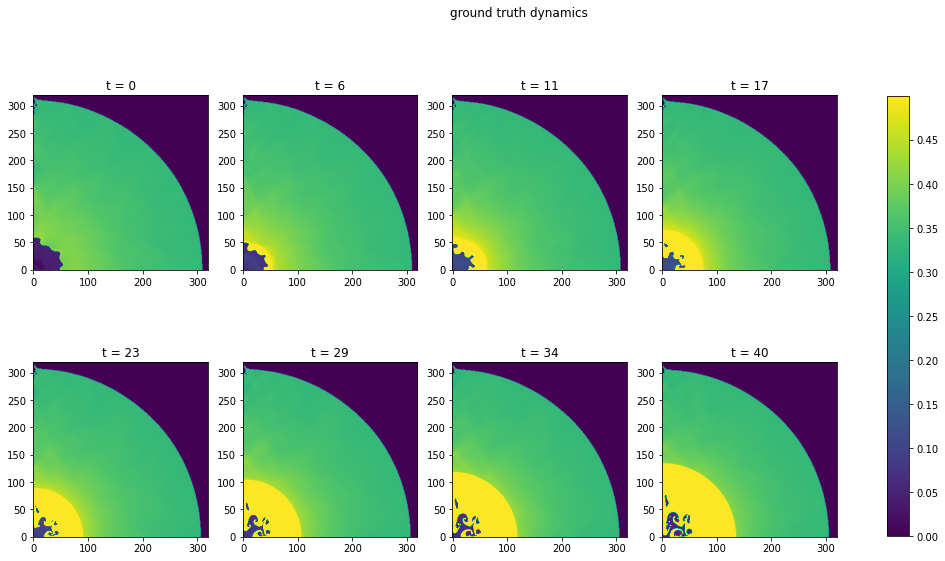

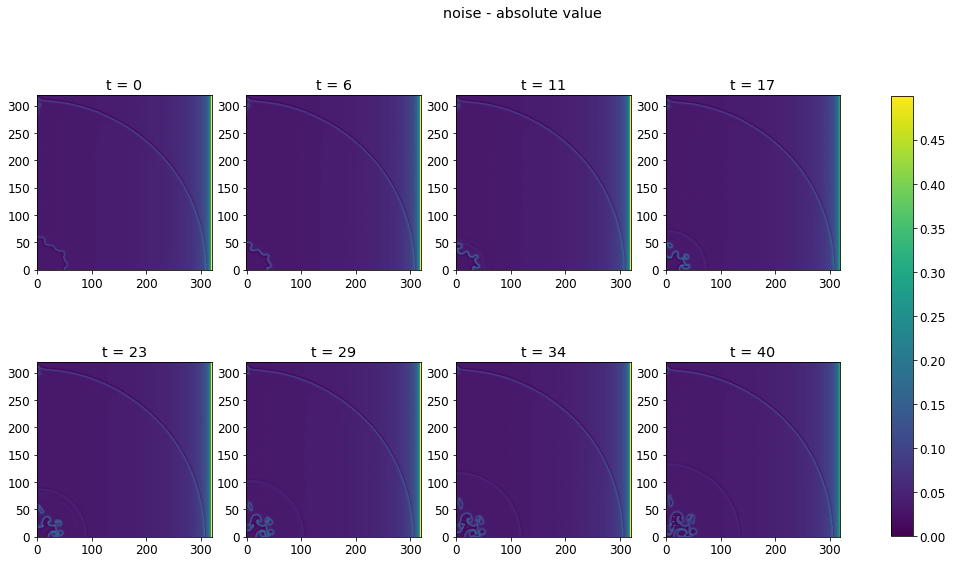

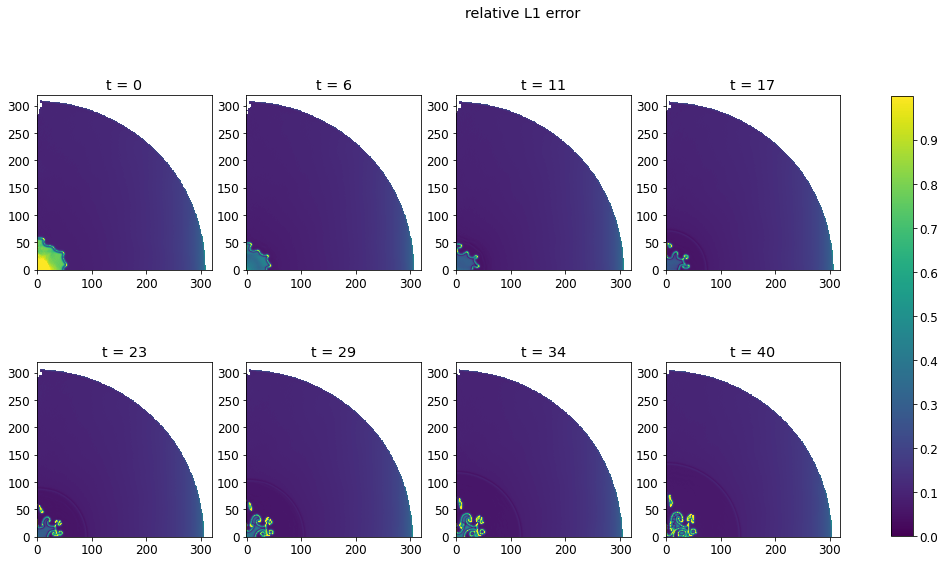

In [39]:
noise[0,0,:,:,:] = noise_generate(dyn[0,0,:,:,:],mode='Abel-gaussian-double',\
                                  sigma=2,volatility=.05,xi=.02,scaling=1,\
                                  abel_method='basex',white_noise_ratio=1e-4) 

noisy_dyn = dyn + noise
%matplotlib inline

vmax_val = .5
illustrate(dyn,                          vmin=0, vmax=vmax_val,title='ground truth dynamics',time_pts=time_pts)
illustrate(noise.abs(),                  vmin=0, vmax=vmax_val,title='noise - absolute value',time_pts=time_pts)
# illustrate(dyn_noisy,                  vmin=noise.min(), vmax=vmax_val,title='noisy dynamics',time_pts=time_pts)
illustrate(torch.divide(noise.abs(),dyn),vmin=0, vmax=1,title='relative L1 error',time_pts=time_pts)

# from IPython.display import clear_output
# plt.figure()
# for i in range(dep):
#     plt.imshow(dyn[0,0,i,:,:],origin='lower')
#     plt.colorbar()
#     plt.clim(0, .8)
# #     plt.title('Frame %d' % (i+1))
#     plt.title('Frame %d' % (i+1+dep*subgroup))
# #     plt.savefig(f'/home/huangz78/checkpoints/frame_{i}.jpg',bbox_inches='tight', transparent=True,
# #                pad_inches=.2, dpi=300)
#     plt.show()
#     clear_output(wait=True)

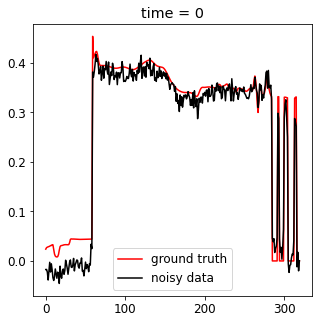

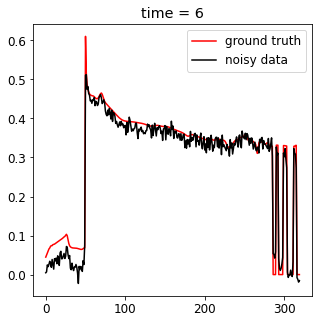

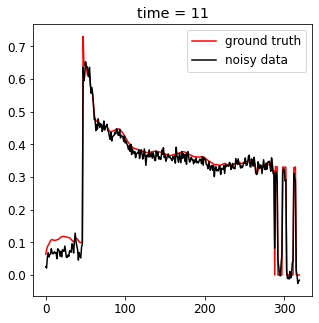

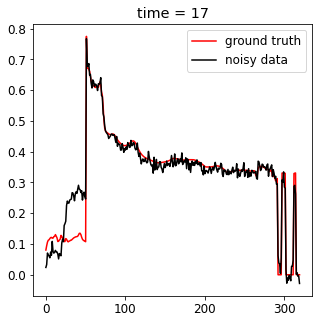

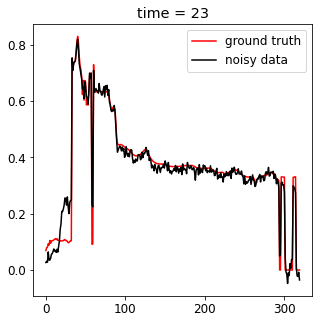

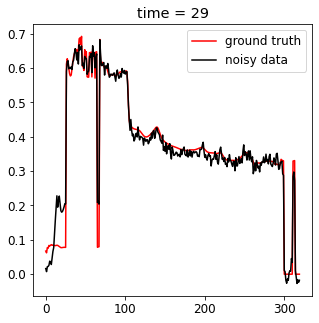

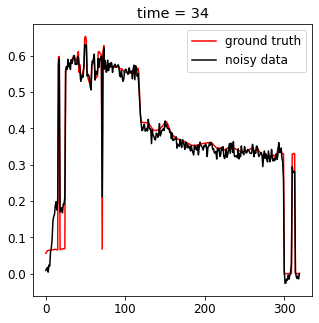

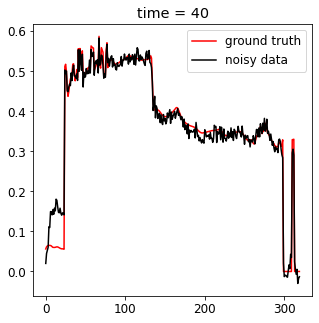

In [38]:
# plot line profile
line_index = 0
plt_range =  320

plt_type = 1

for time_index in range(dep): 
    plt.figure(figsize=(5,5))
    if plt_type == 1: # horizontal line profile
        plt.plot(dyn[0,0,time_index,:plt_range,line_index], 'r', label='ground truth')
        plt.plot(noisy_dyn[0,0,time_index,:plt_range,line_index], 'k', label='noisy data')
#         plt.plot(denoised_dyn[0,0,time_index,:plt_range,line_index], 'g--', linewidth=2 ,label='denoised data')
#         plt.plot(further_denoised_dyn[0,0,time_index,:plt_range,line_index], '--', color='#00FF00',linewidth=3 ,label='post-processed data')
    elif plt_type == 2: # vertical line profile
        plt.plot(dyn[0,0,time_index,line_index,:plt_range], 'r',          label='ground truth')
        plt.plot(noisy_dyn[0,0,time_index,line_index,:plt_range], 'k',    label='noisy data')
#         plt.plot(denoised_dyn[0,0,time_index,line_index,:plt_range], label='denoised data')
#         plt.plot(further_denoised_dyn[0,0,time_index,line_index,:plt_range], label='post-processed data')
    elif plt_type == 3: # diagonal line profile
        gt = [dyn[0,0,time_index,i,i] for i in range(plt_range)]
        noisy_sg = [noisy_dyn[0,0,time_index,i,i] for i in range(plt_range)]
        plt.plot(gt, 'r', label='ground truth')
        plt.plot(noisy_sg, 'k', label='noisy data')
    plt.title(f'time = {time_pts[time_index]}')
    plt.legend(loc='best')
    plt.show()

un-denoised L2 err:  0.24572518467903137
un-denoised L1 err:  0.2026088535785675


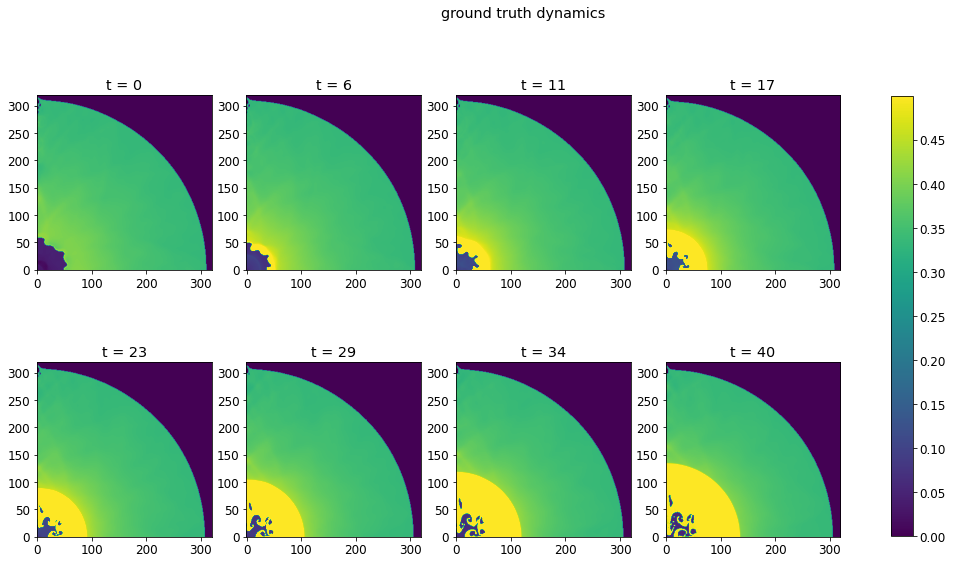

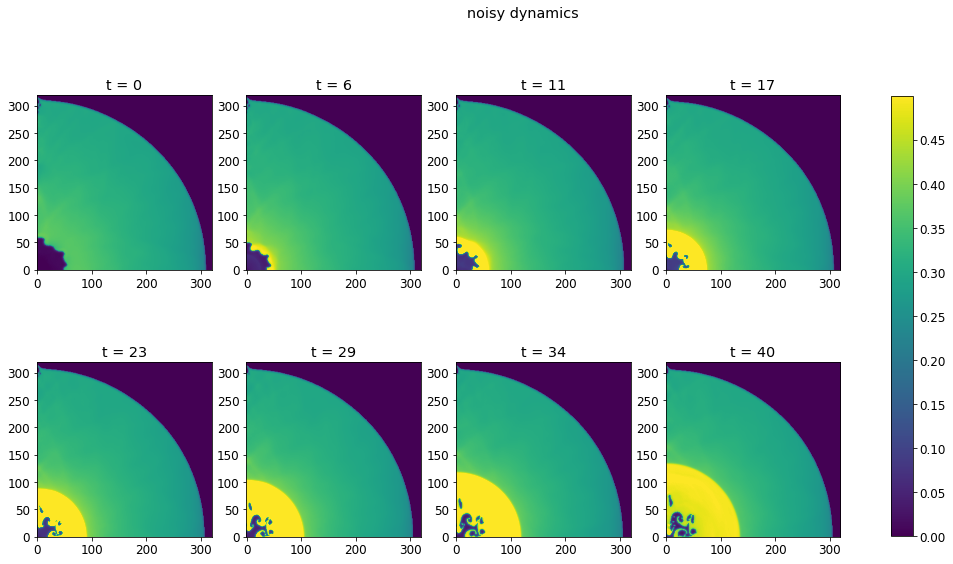

In [36]:
# apply denoiser, show the outcome
noisy_dyn = noise + dyn
# denoised_dyn = gnet(noisy_dyn).clamp(min=0).detach()
# denoised_dyn[dyn==0] = 0
print('un-denoised L2 err: ',(torch.norm(noisy_dyn - dyn)/torch.norm(dyn)).item())
# print('denoised    L2 err: ', (torch.norm(denoised_dyn - dyn)/torch.norm(dyn)).item())
print('un-denoised L1 err: ',(torch.norm(noisy_dyn - dyn,p=1)/torch.norm(dyn,p=1)).item())
# print('denoised    L1 err: ', (torch.norm(denoised_dyn - dyn,p=1)/torch.norm(dyn,p=1)).item())
illustrate(dyn,   vmin=0,vmax=0.5,title='ground truth dynamics',   time_pts=time_pts)
illustrate(noisy_dyn,   vmin=0,vmax=0.5,title='noisy dynamics',   time_pts=time_pts)
# illustrate(denoised_dyn,vmin=0,vmax=0.5,title='denoised dynamics',time_pts=time_pts)

In [ ]:
# plot line profile
line_index = 0
plt_range =  320

plt_type = 1

for time_index in range(dep): 
    plt.figure(figsize=(5,5))
    if plt_type == 1: # horizontal line profile
        plt.plot(dyn[0,0,time_index,:plt_range,line_index], 'r', label='ground truth')
        plt.plot(noisy_dyn[0,0,time_index,:plt_range,line_index], 'k', label='noisy data')
#         plt.plot(denoised_dyn[0,0,time_index,:plt_range,line_index], 'g--', linewidth=2 ,label='denoised data')
#         plt.plot(further_denoised_dyn[0,0,time_index,:plt_range,line_index], '--', color='#00FF00',linewidth=3 ,label='post-processed data')
    elif plt_type == 2: # vertical line profile
        plt.plot(dyn[0,0,time_index,line_index,:plt_range], 'r',          label='ground truth')
        plt.plot(noisy_dyn[0,0,time_index,line_index,:plt_range], 'k',    label='noisy data')
#         plt.plot(denoised_dyn[0,0,time_index,line_index,:plt_range], label='denoised data')
#         plt.plot(further_denoised_dyn[0,0,time_index,line_index,:plt_range], label='post-processed data')
    elif plt_type == 3: # diagonal line profile
        gt = [dyn[0,0,time_index,i,i] for i in range(plt_range)]
        noisy_sg = [noisy_dyn[0,0,time_index,i,i] for i in range(plt_range)]
        plt.plot(gt, 'r',          label='ground truth')
        plt.plot(noisy_sg, 'k',    label='noisy data')
    plt.title(f'time = {time_pts[time_index]}')
    plt.legend(loc='best')
    plt.show()

In [ ]:
truemass = compute_mass(dyn)
further_denoised_dyn = postprocessor(denoised_dyn, truemass,\
                                     lr=1e-5,\
                                     weight_datafid=0, weight_masscon=1e2, weight_TVA=1e-4,\
                                     dyn=dyn,\
                                     maxIter=1e4,\
                                     print_every=500)

In [ ]:
# illustrate(torch.divide((further_denoised_dyn - dyn+1e-10).abs(),dyn+1e-10),vmin=0,vmax=1,title='relative L1 error')
illustrate((further_denoised_dyn - dyn).abs(),vmin=0,vmax=.1,title='absolute L1 error')

## Does netD tells noisy dynamics from clean dynamics?

In [ ]:
# load slices
ngpu = 1
traintotal = 1000
labels_gt = list([])
labels_pred = list([])
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
use_cuda = True if (torch.cuda.is_available() and ngpu > 0) else False
datapath = '/mnt/DataB/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of available files:', len(ncfiles))
print('Train file amount: {}'.format(traintotal))

filestart  = 8000
trainfiles = ncfiles[filestart:filestart+traintotal+800]

In [ ]:
dnet.eval()
device = torch.device('cuda:0')
dnet.to(device)
b_size = 5;  dep = 8; img_size = 320; resize_option = False; noise_mode = 'real'; normalize_factor = 50
with torch.no_grad():
    fileind = 0          
    while fileind < traintotal:
        # set the model back to training mode
        dyn, noise = load_data_batch(fileind, trainfiles, \
                                     b_size=b_size, dep=dep, img_size=img_size,\
                                     resize_option=resize_option,\
                                     noise_mode=noise_mode, normalize_factor=normalize_factor)
        noise    = noise.to(device)
        real_cpu = dyn.to(device)

        label_real = torch.full((b_size,), 1., dtype=torch.float, device=device)
        labels_gt.extend(list(label_real.flatten().cpu().numpy()))
        label_pred = torch.round(dnet(real_cpu).detach())
        labels_pred.extend(list(label_pred.flatten().cpu().numpy()))
        
        label_fake = torch.full((b_size,), 0., dtype=torch.float, device=device)
        labels_gt.extend(list(label_fake.flatten().cpu().numpy()))
        label_pred = torch.round(dnet(real_cpu+noise).detach())
        labels_pred.extend(list(label_pred.flatten().cpu().numpy()))
        
        print(f'current prediction accuracy = {1 - (torch.tensor(labels_pred)- torch.tensor(labels_gt)).abs().sum().item() / len(labels_gt)}')
        fileind += b_size

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_gt, labels_pred)

# Is denoising in the Fourier domain a good idea?

In [ ]:
x  = torch.tensor(np.linspace(0,2*np.pi,256))
y  = torch.sin(x)
z  = torch.ones_like(x) * 0.5
yy = y + z

f  = F.fft(y)
ff = F.fft(yy)

plt.figure()
plt.plot(torch.abs(f[0:50]),label='f')
# plt.plot(torch.abs(ff),label='ff')
plt.legend(loc='best')
# plt.yscale('log')
plt.show()

plt.figure()
# plt.plot(torch.abs(f),label='f')
plt.plot(torch.abs(ff[0:50]),label='ff')
plt.legend(loc='best')
# plt.yscale('log')
plt.show()

# check conservation of mass

In [ ]:
datapath = '/mnt/shared_b/data/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 41

batchsize = 5
fileexp_inds = [7736+i for i in range(batchsize)]

dyn   = torch.zeros((batchsize,1,dep,img_size,img_size))    # load one sample, show it
noise = torch.zeros((batchsize,1,dep,img_size,img_size))    # make a noise sample, add it to the ground truth, show it

for fileexp_ind in range(len(fileexp_inds)):
    filename = ncfiles[fileexp_inds[fileexp_ind]]
    sim = xr.open_dataarray(datapath+filename)
    # val.append(np.max(np.array(sim)[:dep,:,:].flatten()))
    sim.close()
    for t in range(dep):
        dyn[fileexp_ind,0,t,:,:] = torch.tensor( sim.isel(t=t)[:img_size,:img_size].values )

# dyn   = np.zeros((1,1,dep,256,256))    # load one sample, show it
# noise = np.zeros((1,1,dep,256,256))    # make a noise sample, add it to the ground truth, show it
# for t in range(dep):
#     dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)

In [ ]:
# check conservation of mass

mass = np.zeros(dep)
for ind in range(dep):
    img = dyn[0,0,ind,:,:]
    mass[ind] = integration_over_sphere(img)
plt.scatter(range(dep),mass)
plt.show()

In [ ]:
img = dyn[0,0,0,:,:]
plt.imshow(img,origin='lower')
plt.colorbar()
plt.show()

In [ ]:
def compute_mass(imgs,Rrho=1,Rz=1):
    '''
    computing through cylindrical coordinate
    '''
    drho = Rrho / imgs.shape[3]
    dz   = Rz   / imgs.shape[4]
    metrics = torch.linspace(0,Rrho,imgs.shape[4]).repeat(imgs.shape[3],1)
    integrand = imgs * metrics
    mass = 2*np.pi * torch.sum(integrand,dim=(3,4)) * drho * dz 
    return torch.squeeze(mass)

In [ ]:
compute_mass(dyn)

In [ ]:
mass = np.zeros(dep)
for ind in range(dep):
    img = dyn[0,0,ind,:,:]
    mass[ind] = compute_mass(img)
plt.scatter(range(dep),mass)
plt.show()

In [ ]:
def compute_mass(rho, R, z):
    dR = R[1] - R[0]
    dz = z[1] - z[0]
    m = sum(2*np.pi*R[:]*rho[:])*dR*dz
    return m

In [ ]:
grid_r, grid_theta = np.mgrid[0:1:301j, np.pi/2:np.pi:301j]

In [ ]:
plt.imshow(grid_r.T,origin='lower')
plt.colorbar()
plt.title('r grid')
plt.show()

plt.imshow(grid_theta.T,origin='lower')
plt.colorbar()
plt.title('theta grid')
plt.show()

In [ ]:
def integration_over_sphere(img,img_size=320,grid_len=300,method='cubic',R=1,Rx=1,Ry=1):
    
    grid_r, grid_theta = np.mgrid[0:R:301j, np.pi/2:np.pi:301j]
    dr = 1/grid_len
    dtheta = np.pi/(2*grid_len)
    Cartesian_grid = [[i/img_size*Rx,j/img_size*Ry] for i in range(img_size) for j in range(img_size)]
    radius = lambda x,y: np.sqrt(x**2 + y**2)
    theta  = lambda x,y: np.arctan(x/y) + np.pi/2
    
    Spherical_grid = []
    vals = []
    for point in Cartesian_grid:
        if point[0]==0:
            Spherical_grid.append([point[1],np.pi/2])
        elif (point[1]==0) and (point[0]!=0):
            Spherical_grid.append([point[0],np.pi])
        else:
            Spherical_grid.append([radius(point[0],point[1]),theta(point[0],point[1])])
        vals.append(img[int(point[0]*img_size/Rx),int(point[1]*img_size/Ry)])
        
    Spherical_grid = np.array(Spherical_grid)
#     Cartesian_grid = np.array(Cartesian_grid)
    vals = np.array(vals)

    den_interp = griddata(Spherical_grid, vals, (grid_r, grid_theta), method=method).T
    metric = (grid_r.T)**2 * np.sin(grid_theta.T)
    
    mass = np.sum(metric * np.nan_to_num(den_interp)) * dr * dtheta
    
    return mass

In [ ]:
plt.scatter(Spherical_grid[:,0],Spherical_grid[:,1],c=vals)
plt.xlabel('radius')
plt.ylabel('theta')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(den_interp.T, extent=(0,1,np.pi/2,np.pi), origin='lower')
plt.title('Cubic interpolation')
plt.gcf().set_size_inches(6, 6)
plt.colorbar()
plt.xlabel('radius')
plt.ylabel('theta')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Spherical_grid[:,0],Spherical_grid[:,1],vals)
ax.set_xlabel('r')
ax.set_ylabel('theta')
ax.set_zlabel('val')
plt.show()

In [ ]:
dyn = np.loadtxt('/home/huangz78/hydro/leo1_trada.txt')
heg = 860
wid = 880
dx = 2.558140 * 1e-2 
dy = 2.500000 * 1e-2
dyn = np.reshape(dyn,(heg,wid))
Rx = dx * 320
Ry = dy * 320
R  = min(Rx,Ry)

plt.figure(figsize=(10,8))
plt.imshow(dyn)
plt.colorbar()
plt.show()

In [ ]:
imgslice = dyn[heg//2:heg//2+320,wid//2:wid//2+320]
plt.imshow(imgslice)
plt.colorbar()
plt.show()

In [ ]:
integration_over_sphere(imgslice,R=R,Rx=Rx,Ry=Ry)

In [ ]:
heg = 860
wid = 880
dx = 2.558140 * 1e-2 
dy = 2.500000 * 1e-2

weights = np.array([[i**2+j**2 for j in (np.arange(0,wid)-wid//2)*dy] for i in (np.arange(0,heg)-heg//2)*dx])
plt.figure(figsize=(10,8))
plt.imshow(weights)
plt.colorbar()
plt.show()

summation = np.sum(np.multiply(weights,dyn))*(dx*dy)*4/3*np.pi
print(summation)

# summation = np.zeros((dep))
# for t in range(dep):
#     summation[t] = np.sum(np.multiply(weights,dyn[0,0,t,:,:]))
# plt.figure()
# plt.scatter(range(dep),summation)
# plt.xlabel('frame number')
# plt.ylabel('weighted summation of pixels')
# plt.show()

In [ ]:
weights = np.array([[i**2+j**2 for i in np.arange(0,img_size)/img_size] for j in np.arange(0,img_size)/img_size])
plt.figure()
plt.imshow(weights)
plt.colorbar()
plt.show()

summation = np.zeros((dep))
for t in range(dep):
    summation[t] = np.sum(np.multiply(weights,dyn[0,0,t,:,:]))
plt.figure()
plt.scatter(range(dep),summation)
plt.xlabel('frame number')
plt.ylabel('weighted summation of pixels')
plt.show()

In [ ]:
import datetime
import imageio
def create_gif(filenames, duration):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = '/home/huangz78/checkpoints/Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, duration=duration)

In [ ]:
filenames=[f'/home/huangz78/checkpoints/frame_{i}.jpg' for i in range(41)]

In [ ]:
create_gif(filenames, .4)